In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pokemon-pokedex/Pokemon.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [3]:
pokemon = pd.read_csv('/kaggle/input/pokemon-pokedex/Pokemon.csv')

In [4]:
pokemon.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False


In [5]:
pokemon.tail(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
1094,1016,Fezandipiti,Poison,Fairy,555,88,91,82,70,125,99,9,True
1095,1017,Ogerpon,Grass,NaN,550,80,120,84,60,96,110,9,True
1096,1018,Archaludon,Steel,Dragon,600,90,105,130,125,65,85,9,True
1097,1019,Hydrapple,Grass,Dragon,540,106,80,110,120,80,44,9,True
1098,1020,Gouging Fire,Fire,Dragon,590,105,115,121,65,93,91,9,True
1099,1021,Raging Bolt,Electric,Dragon,590,125,73,91,137,89,75,9,True
1100,1022,Iron Boulder,Rock,Dragon,590,90,120,80,68,108,124,9,True
1101,1023,Iron Crown,Steel,Psychic,590,90,72,100,122,108,98,9,True
1102,1024,Terapagos,Normal,NaN,700,160,105,110,130,110,85,9,True
1103,1025,Pecharunt,Poison,Ghost,600,88,88,160,88,88,88,9,True


In [6]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           1104 non-null   int64 
 1   Name        1104 non-null   object
 2   Type 1      1104 non-null   object
 3   Type 2      592 non-null    object
 4   Total       1104 non-null   int64 
 5   HP          1104 non-null   int64 
 6   Attack      1104 non-null   int64 
 7   Defense     1104 non-null   int64 
 8   Sp. Atk     1104 non-null   int64 
 9   Sp. Def     1104 non-null   int64 
 10  Speed       1104 non-null   int64 
 11  Generation  1104 non-null   int64 
 12  Legendary   1104 non-null   bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 104.7+ KB


Data Cleaning

In [7]:
missing_values = pokemon.iloc[:, :10].isnull().sum()

missing_values

#            0
Name         0
Type 1       0
Type 2     512
Total        0
HP           0
Attack       0
Defense      0
Sp. Atk      0
Sp. Def      0
dtype: int64

In [8]:
# Drop rows with any NaN values
pokemon_dropped_rows = pokemon.dropna(axis=0) 

print(pokemon_dropped_rows)

         #                   Name    Type 1   Type 2  Total   HP  Attack  \
0        1              Bulbasaur     Grass   Poison    318   45      49   
1        2                Ivysaur     Grass   Poison    405   60      62   
2        3               Venusaur     Grass   Poison    525   80      82   
3        3  VenusaurMega Venusaur     Grass   Poison    625   80     100   
6        6              Charizard      Fire   Flying    534   78      84   
...    ...                    ...       ...      ...    ...  ...     ...   
1098  1020           Gouging Fire      Fire   Dragon    590  105     115   
1099  1021            Raging Bolt  Electric   Dragon    590  125      73   
1100  1022           Iron Boulder      Rock   Dragon    590   90     120   
1101  1023             Iron Crown     Steel  Psychic    590   90      72   
1103  1025              Pecharunt    Poison    Ghost    600   88      88   

      Defense  Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0          49       65 

In [9]:
# Remove duplicate rows based on all columns
pokemon_new = pokemon_dropped_rows.drop_duplicates()

print(pokemon_new)

         #                   Name    Type 1   Type 2  Total   HP  Attack  \
0        1              Bulbasaur     Grass   Poison    318   45      49   
1        2                Ivysaur     Grass   Poison    405   60      62   
2        3               Venusaur     Grass   Poison    525   80      82   
3        3  VenusaurMega Venusaur     Grass   Poison    625   80     100   
6        6              Charizard      Fire   Flying    534   78      84   
...    ...                    ...       ...      ...    ...  ...     ...   
1098  1020           Gouging Fire      Fire   Dragon    590  105     115   
1099  1021            Raging Bolt  Electric   Dragon    590  125      73   
1100  1022           Iron Boulder      Rock   Dragon    590   90     120   
1101  1023             Iron Crown     Steel  Psychic    590   90      72   
1103  1025              Pecharunt    Poison    Ghost    600   88      88   

      Defense  Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0          49       65 

In [10]:
pokemon_new.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,529.255068,466.305743,73.175676,85.001689,80.366554,78.570946,76.684122,72.391892,4.827703
std,297.706895,117.172871,24.394173,32.913438,31.520881,33.029982,27.036227,29.295307,2.613393
min,1.000000,185.000000,1.000000,10.000000,15.000000,10.000000,20.000000,5.000000,1.000000
25%,276.750000,380.000000,56.750000,60.000000,58.000000,54.000000,55.000000,50.000000,3.000000
50%,541.500000,485.000000,70.000000,82.000000,78.000000,72.500000,75.000000,70.000000,5.000000
75%,774.500000,540.000000,90.000000,109.000000,100.000000,100.000000,95.000000,95.000000,7.000000
max,1025.000000,780.000000,223.000000,190.000000,230.000000,180.000000,230.000000,160.000000,9.000000


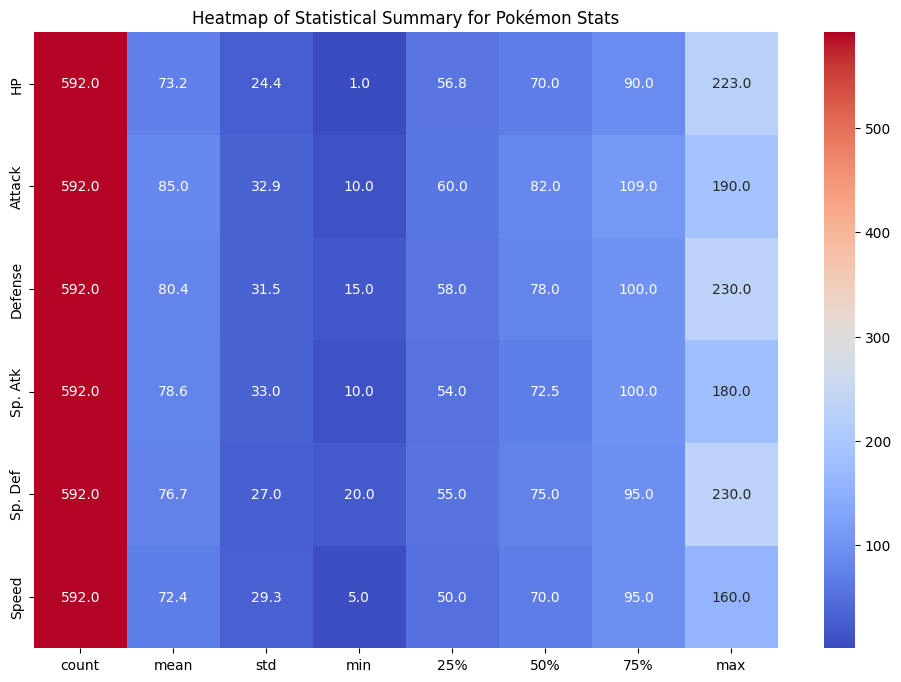

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'pokemon_df' is your original DataFrame and contains the data of interest
numeric_columns = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
pokemon_stats_describe = pokemon_new[numeric_columns].describe()

pokemon_new = pokemon_stats_describe.transpose()

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pokemon_new, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Heatmap of Statistical Summary for Pokémon Stats')
plt.show()

Top 10 Pokemon 

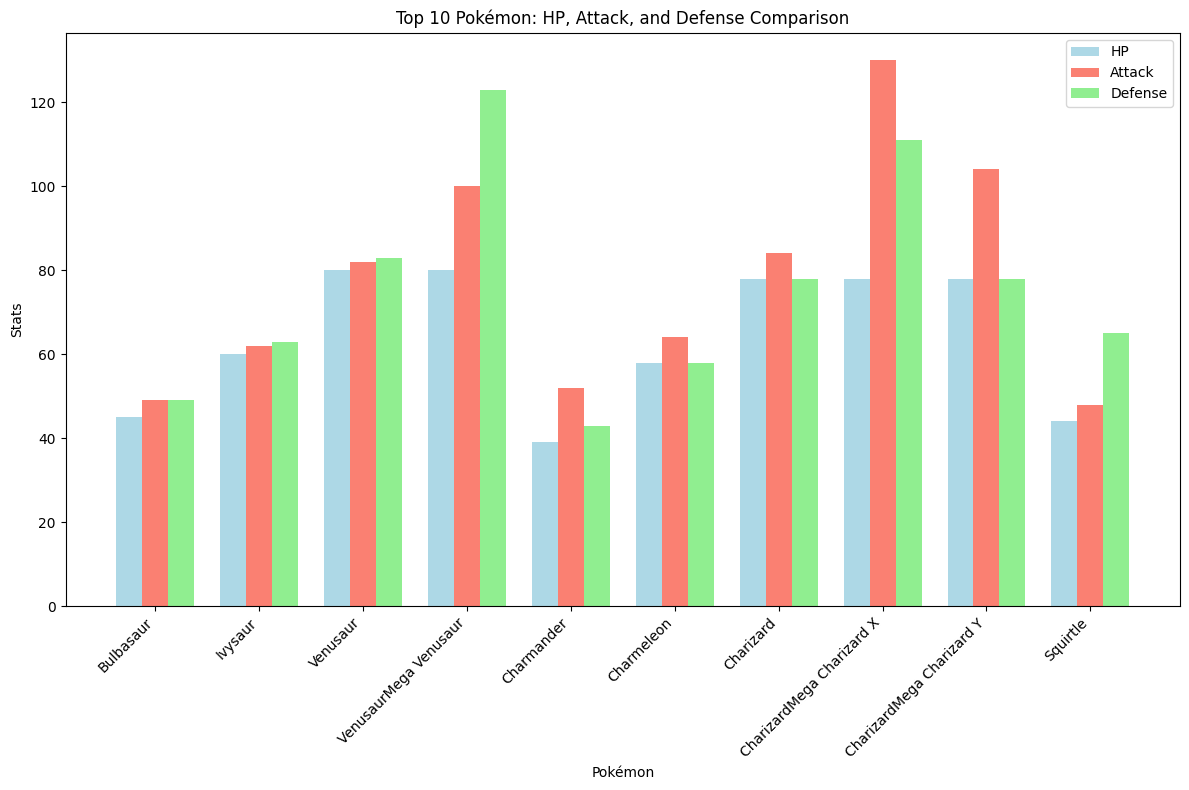

In [22]:
# Selecting the top 10 Pokémon for visualization
top_10_pokemon = pokemon.head(10)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Setting the positions and width for the bars
positions = np.arange(len(top_10_pokemon))
bar_width = 0.25

# Plotting each stat
hp_bars = ax.bar(positions - bar_width, top_10_pokemon['HP'], bar_width, label='HP', color='lightblue')
attack_bars = ax.bar(positions, top_10_pokemon['Attack'], bar_width, label='Attack', color='salmon')
defense_bars = ax.bar(positions + bar_width, top_10_pokemon['Defense'], bar_width, label='Defense', color='lightgreen')

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Pokémon')
ax.set_ylabel('Stats')
ax.set_title('Top 10 Pokémon: HP, Attack, and Defense Comparison')
ax.set_xticks(positions)
ax.set_xticklabels(top_10_pokemon['Name'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

Convert to numpy

In [11]:
# Selecting only the numeric columns for conversion
numeric_columns = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
pokemon_numeric = pokemon_new[numeric_columns].to_numpy()

# Show the shape of the numpy array to confirm conversion
pokemon_numeric.shape

(592, 6)

In [12]:
pokemon_numeric

array([[ 45,  49,  49,  65,  65,  45],
       [ 60,  62,  63,  80,  80,  60],
       [ 80,  82,  83, 100, 100,  80],
       ...,
       [ 90, 120,  80,  68, 108, 124],
       [ 90,  72, 100, 122, 108,  98],
       [ 88,  88, 160,  88,  88,  88]])

Data Visualization

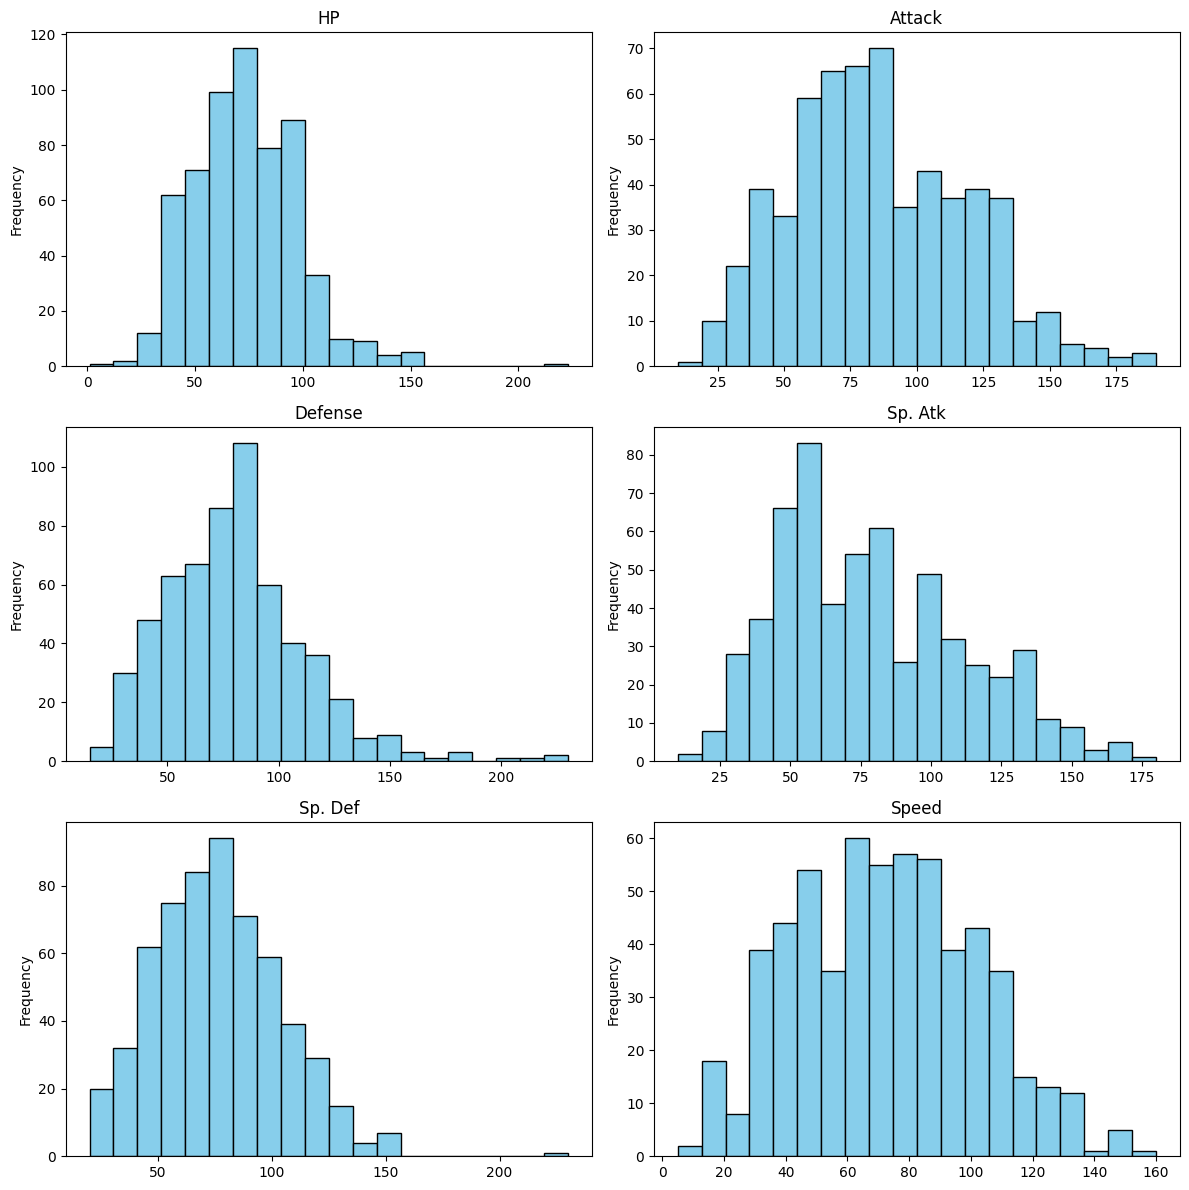

In [13]:
import matplotlib.pyplot as plt

# Creating histograms for each of the stats
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, stat in enumerate(numeric_columns):
    axes[i].hist(pokemon_numeric[:, i], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(stat)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Predict a Pokémon's Speed

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

# Assuming pokemon_numeric is our features and we're predicting Speed
# Let's separate Speed from the other stats
X = np.delete(pokemon_numeric, 5, axis=1)  # All stats except Speed
y = pokemon_numeric[:, 5]  # Only Speed

# Splitting the data into training and testing sets for demonstration purposes
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a simple neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# Model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)